In [1]:
import os
import nibabel as nib
from utils import crop_image, generate_patient_info_brain, preprocess_brain
import numpy as np
from PIL import Image

In [ ]:
patient_info = generate_patient_info_brain("data/brain/structured/", True)

if not os.path.exists("data/brain/"):
    os.makedirs("data/brain/")  
np.save(os.path.join("data/brain/preprocessed/", "patient_info"), patient_info)

In [2]:
patient_info = np.load("data/brain/preprocessed/patient_info.npy", allow_pickle=True).item()

In [20]:
np.median(np.array([patient_info[key]["spacing"] for key in patient_info.keys()]), axis=0)

array([1.25  , 0.9375, 0.9375], dtype=float32)

In [5]:
dataBrain = nib.load('data/brain/structured/patient001/image.nii.gz').get_fdata()
dataHeart = nib.load('data/heart/training/patient001/patient001_frame01.nii.gz').get_fdata()

In [ ]:
fname = "data/brain/structured/patient005/mask.nii.gz"
np.array(nib.load(fname).get_fdata().astype(int))

In [3]:
spacing_target = [10, 0.93, 0.93]

if not os.path.exists("data/brain/preprocessed"):
    os.makedirs("data/brain/preprocessed")
    
preprocess_brain(
    range(0,444), patient_info, spacing_target,
    "data/brain/structured/", "data/brain/preprocessed",
    lambda folder, id: os.path.join(folder, 'patient{:03d}'.format(id)),
    lambda : "mask.nii.gz",
    skip=[9],
    verbose=False
    )

Finished processing patient 000
Finished processing patient 010
Finished processing patient 020
Finished processing patient 030
Finished processing patient 040
Finished processing patient 050
Finished processing patient 060
Finished processing patient 070
Finished processing patient 080
Finished processing patient 090
Finished processing patient 100
Finished processing patient 110
Finished processing patient 120
Finished processing patient 130
Finished processing patient 140
Finished processing patient 150
Finished processing patient 160
Finished processing patient 170
Finished processing patient 180
Finished processing patient 190
Finished processing patient 200
Finished processing patient 210
Finished processing patient 220
Finished processing patient 230
Finished processing patient 240
Finished processing patient 250
Finished processing patient 260
Finished processing patient 270
Finished processing patient 280
Finished processing patient 290
Finished processing patient 300
Finished

# Dataset

In [18]:
import os
import numpy as np
import random
import torchvision
from utils import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform

In [22]:
ids = random.sample(range(1, 301), 50)
train_ids = ids[:40]
val_ids = ids[40:]

transform = torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation = torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256), angle_x=(-np.pi/6,np.pi/6), scale=(0.7,1.4), random_crop=True),
    OneHot(),
    ToTensor()
])

In [23]:
try: 
    train_ids.remove(9)
    # break
except ValueError:
    try:
        val_ids.remove(9)
    except ValueError:
        pass

# Training

In [25]:
import sys, importlib
import CA
importlib.reload(sys.modules['CA'])
importlib.reload(sys.modules['utils'])

import torch
from CA import AE, plot_history, hyperparameter_tuning
from utils import SYNDalaLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#the following cell allows the user to tune his own hyperparameters. In case you wanna try our hyperparameters first, just skip this cell.

#this is a list of possible values being tested for each hyperparameter.
parameters = {
    "DA": [True, False], #data augmentation
    "latent_size": [100, 500], #size of the latent space of the autoencoder
    "BATCH_SIZE": [8, 16, 4],
    "optimizer": [torch.optim.Adam],
    "lr": [2e-4, 1e-4, 1e-3],
    "weight_decay": [1e-5],
    "tuning_epochs": [5, 10], #number of epochs each configuration is run for
    "functions": [["GDLoss", "MSELoss"], ["GDLoss"], ["BKGDLoss", "BKMSELoss"]], #list of loss functions to be evaluated. BK stands for "background", which is a predominant and not compulsory class (it can lead to a dumb local minimum retrieving totally black images).
    "settling_epochs_BKGDLoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKGDLoss
    "settling_epochs_BKMSELoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKMSELoss
}

#this is a list of rules cutting out some useless combinations of hyperparameters from the tuning process.
rules = [
    '"settling_epochs_BKGDLoss" == 0 or "BKGDLoss" in "functions"',
    '"settling_epochs_BKMSELoss" == 0 or "BKMSELoss" in "functions"',
    '"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" <= "tuning_epochs"',
    '"BKMSELoss" not in "functions" or "settling_epochs_BKMSELoss" <= "tuning_epochs"',
    #'"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" >= "settling_epochs_BKMSELoss"'
]

optimal_parameters = hyperparameter_tuning(
    parameters,
    SYNDalaLoader("data/brain/preprocessed/", patient_ids=train_ids, batch_size=None, transform=None),
    SYNDalaLoader("data/brain/preprocessed/", patient_ids=val_ids, batch_size=None, transform=None),
    transform, transform_augmentation,
    rules,
    fast=True) #very important parameter. When False, all combinations are tested to return the one retrieving the maximum DSC. When True, the first combination avoiding dumb local minima is returned.


np.save(os.path.join("data/brain/preprocessed/", "optimal_parameters"), optimal_parameters)

AE(
  (encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.5, inplace=False

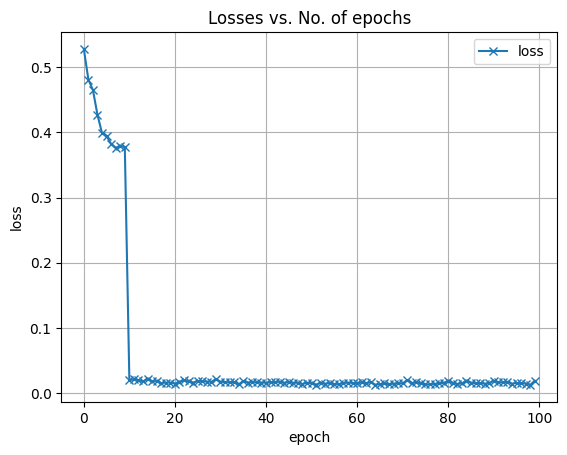

In [28]:
upload_your_own_parameters = False

if upload_your_own_parameters:
    optimal_parameters = np.load(os.path.join("data/brain/preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
else:
    optimal_parameters = {
        "BATCH_SIZE": 8,
        "DA": False,
        "latent_size": 100,
        "optimizer": torch.optim.Adam,
        "lr": 2e-4,
        "weight_decay": 1e-5,
        "functions": ["BKGDLoss", "BKMSELoss"],
        "settling_epochs_BKGDLoss": 10,
        "settling_epochs_BKMSELoss": 0
    }
    np.save(os.path.join("data/brain/preprocessed/", "optimal_parameters"), optimal_parameters)

assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

BATCH_SIZE = optimal_parameters["BATCH_SIZE"]
DA = optimal_parameters["DA"]

ae = AE(**optimal_parameters).to(device)

ckpt = None
if ckpt is not None:
    ckpt = torch.load(ckpt)
    ae.load_state_dict(ckpt["AE"])
    ae.optimizer.load_state_dict(ckpt["AE_optim"])
    start = ckpt["epoch"]+1
else:
    start = 0

print(ae)

plot_history(
    ae.training_routine(
        range(start, 100),
        SYNDalaLoader("data/brain/preprocessed/", patient_ids=train_ids, batch_size=BATCH_SIZE, transform=transform_augmentation if DA else transform),
        SYNDalaLoader("data/brain/preprocessed/", patient_ids=val_ids, batch_size=BATCH_SIZE, transform=transform),
        "data/brain/checkpoints/"
    )
)